In [1]:

import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Path to your dataset
DATASET_DIR = r"E:\CP Dataset\cwt"

# Class Names (must match folder names)
CLASS_NAMES = [
    'Normal (3BAR)',
    'Impeller (3.0BAR)',
    'Mechanical seal Hole (3BAR)',
    'Mechanical seal Scratch (3.0BAR)'
]
LABEL_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
print("Label Mapping:", LABEL_MAP)

# Load images and labels
images, labels = [], []
for class_name in CLASS_NAMES:
    class_path = os.path.join(DATASET_DIR, class_name)
    for img_file in os.listdir(class_path):
        try:
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).convert("RGB").resize((224, 224))
            images.append(np.array(img) / 255.0)
            labels.append(LABEL_MAP[class_name])
        except Exception as e:
            print(f"Failed to load {img_file}: {e}")

# Convert to arrays
X = np.array(images)
y = to_categorical(np.array(labels), num_classes=len(CLASS_NAMES))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Dataset Shapes:")
print("X:", X.shape, "y:", y.shape)
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)



Label Mapping: {'Normal (3BAR)': 0, 'Impeller (3.0BAR)': 1, 'Mechanical seal Hole (3BAR)': 2, 'Mechanical seal Scratch (3.0BAR)': 3}
Dataset Shapes:
X: (1247, 224, 224, 3) y: (1247, 4)
Train: (997, 224, 224, 3) (997, 4)
Test: (250, 224, 224, 3) (250, 4)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.3862 - loss: 1.3141 - val_accuracy: 0.6800 - val_loss: 0.9474
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7568 - loss: 0.8725 - val_accuracy: 0.7500 - val_loss: 0.7270
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.8076 - loss: 0.6733 - val_accuracy: 0.7700 - val_loss: 0.5998
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.7725 - loss: 0.5794 - val_accuracy: 0.8350 - val_loss: 0.5167
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.8500 - loss: 0.4983 - val_accuracy: 0.8450 - val_loss: 0.4711
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - accuracy: 0.8838 - loss: 0.4466 - val_accuracy: 0.8300 - val_loss: 0.4432
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step - accuracy: 0.8987 - loss: 0.4056 - val_accuracy: 0.8400 - val_loss: 0.4209
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.8981 - loss: 0.3819 - val_accuracy: 0

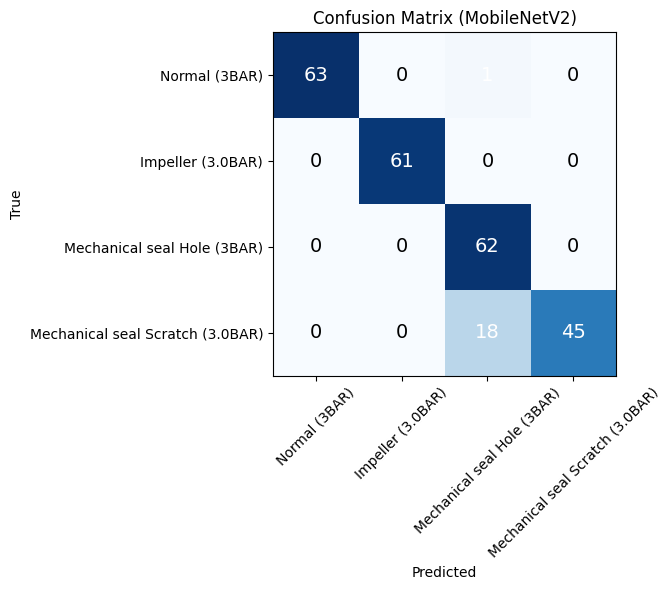

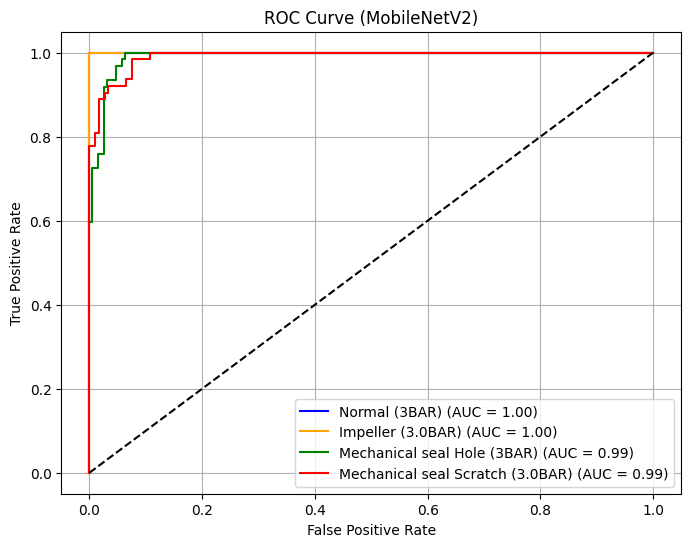

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step


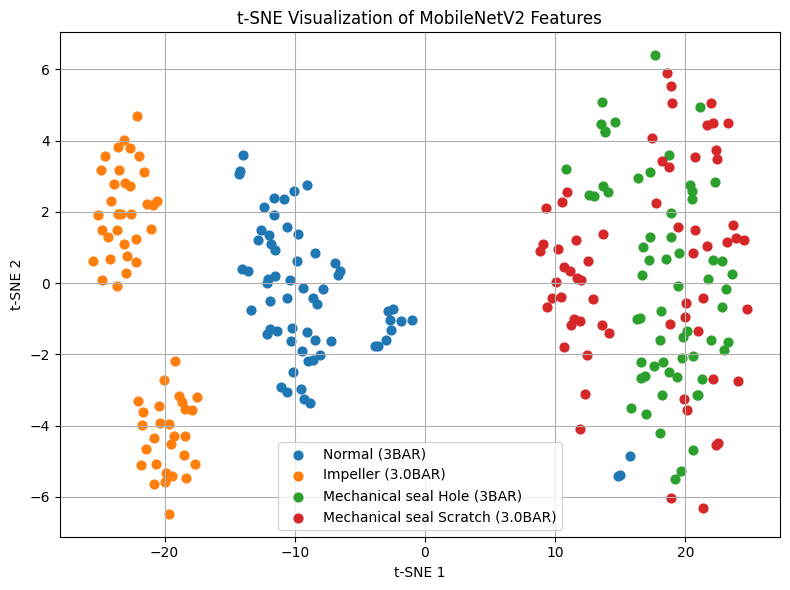

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import plot_model

# Load your preprocessed dataset
# Assume you have already loaded: X_train, y_train, X_test, y_test

# Step 1: Load MobileNetV2 as Baseline
input_shape = (224, 224, 3)
base_model = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(4, activation='softmax')(x)
comparison_model = Model(inputs=base_model.input, outputs=outputs)

# Freeze base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

comparison_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 2: Train
history = comparison_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Step 3: Predict
y_pred_probs = comparison_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Step 4: Evaluation Report
print(classification_report(y_true, y_pred, target_names=list(LABEL_MAP.keys())))

# Step 5: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > 0 else 'black', fontsize=14)
plt.xticks(ticks=np.arange(4), labels=list(LABEL_MAP.keys()), rotation=45)
plt.yticks(ticks=np.arange(4), labels=list(LABEL_MAP.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
#plt.title("Confusion Matrix (MobileNetV2)")
plt.tight_layout()
plt.show()

# Step 6: ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred_probs[:, i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red']
for i, class_name in enumerate(LABEL_MAP.keys()):
    plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc[i]:.2f})", color=colors[i])
plt.plot([0, 1], [0, 1], 'k--')
#plt.title('ROC Curve (MobileNetV2)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# Step 7: t-SNE Feature Visualization
intermediate_layer_model = Model(inputs=comparison_model.input, outputs=comparison_model.layers[-2].output)
features = intermediate_layer_model.predict(X_test)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
for i, label in enumerate(LABEL_MAP.keys()):
    plt.scatter(tsne_result[y_true == i, 0], tsne_result[y_true == i, 1], label=label, s=40)
plt.title("t-SNE Visualization of MobileNetV2 Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [3]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_model(model, name, dataloader, classes, device):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
            all_probabilities.extend(probs)

    # === Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=classes, output_dict=True)

    # 🔢 Overall Metrics
    print(f"\n📊 Overall Accuracy: {report['accuracy']*100:.2f}%")
    print(f"🧠 Weighted Precision: {report['weighted avg']['precision']:.2f}")
    print(f"🧠 Weighted Recall: {report['weighted avg']['recall']:.2f}")
    print(f"🧠 Weighted F1 Score: {report['weighted avg']['f1-score']:.2f}")

    # 🔍 Per-Class Metrics
    print("\n🔍 Per-Class Metrics:")
    for cls in classes:
        metrics = report[cls]
        print(f"\n🟢 Class '{cls}':")
        print(f"   Precision: {metrics['precision']:.2f}")
        print(f"   Recall:    {metrics['recall']:.2f}")
        print(f"   F1 Score:  {metrics['f1-score']:.2f}")

    # 📊 Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, cbar=False,
                annot_kws={"size": 16, "fontweight": "bold"})
    plt.xlabel("Predicted", fontsize=14, fontweight="bold")
    plt.ylabel("True", fontsize=14, fontweight="bold")
    plt.xticks(rotation=45, fontweight="bold")
    plt.yticks(rotation=0, fontweight="bold")
    plt.tight_layout()
    plt.savefig(f"{name}_confusion_matrix.png", dpi=1000)
    plt.show()

    # 📈 ROC Curve (Multiclass)
    num_classes = len(classes)
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(all_probabilities)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{name}_ROC_curve.png", dpi=1000)
    plt.show()


In [6]:
evaluate_model(
    model=comparison_model,                # ✅ Your MobileNetV2 model
    name="MobileNetV2_CP_Comparison",      # ✅ Output filenames prefix
    dataloader=test_dataset,               # ✅ Replace this with your actual test DataLoader (or custom loader)
    classes=[
        'Normal',
        'Impeller',
        'Mechanical seal Hole',
        'Mechanical seal Scratch'
    ],
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Needed only if using PyTorch
)


NameError: name 'test_dataset' is not defined

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_tf_model(model, X_test, y_test, class_names, save_prefix="model_eval"):
    y_probs = model.predict(X_test)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report
    print("\n📊 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 14, "weight": "bold"})
    plt.xlabel("Predicted", fontsize=13, weight="bold")
    plt.ylabel("True", fontsize=13, weight="bold")
    plt.xticks(rotation=45, weight="bold")
    plt.yticks(rotation=0, weight="bold")
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_confusion_matrix.png", dpi=1000)
    plt.show()

    # ROC Curve
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate", fontsize=13)
    plt.ylabel("True Positive Rate", fontsize=13)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_ROC_curve.png", dpi=1000)
    plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step

📊 Classification Report:

                         precision    recall  f1-score   support

                 Normal       1.00      0.98      0.99        64
               Impeller       1.00      1.00      1.00        61
   Mechanical seal Hole       0.77      1.00      0.87        62
Mechanical seal Scratch       1.00      0.71      0.83        63

               accuracy                           0.92       250
              macro avg       0.94      0.92      0.92       250
           weighted avg       0.94      0.92      0.92       250



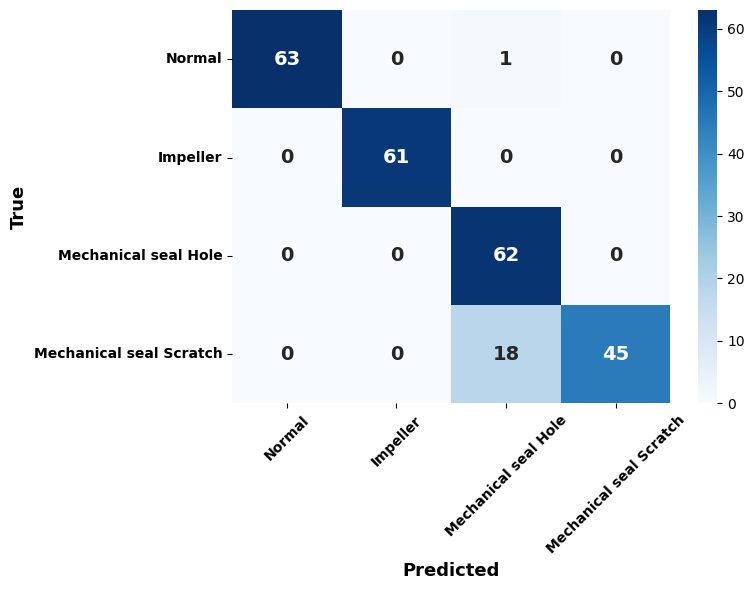

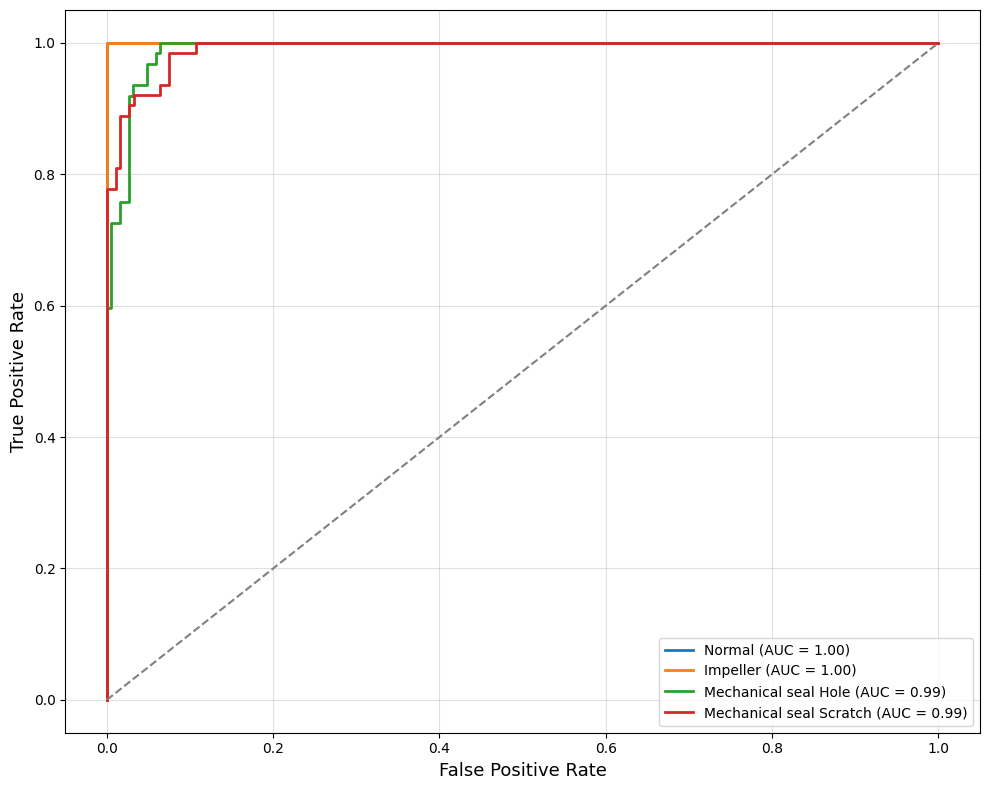

In [8]:
evaluate_tf_model(
    model=comparison_model,
    X_test=X_test,
    y_test=y_test,
    class_names=[
        'Normal',
        'Impeller',
        'Mechanical seal Hole',
        'Mechanical seal Scratch'
    ],
    save_prefix="MobileNetV2_CP"
)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step


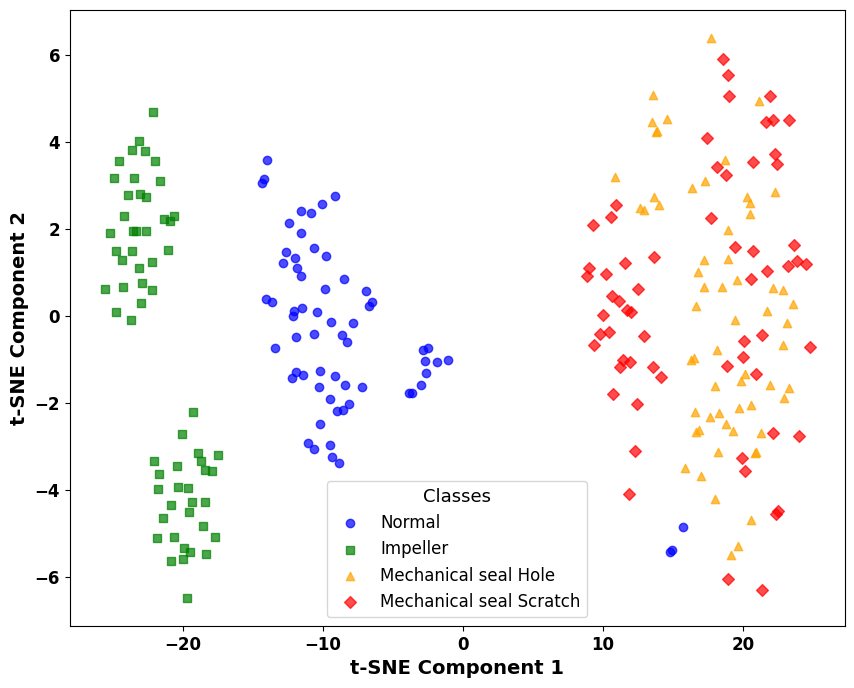

In [9]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 1: Create a Feature Extractor Model (remove classifier)
feature_extractor = Model(
    inputs=comparison_model.input,
    outputs=comparison_model.layers[-2].output  # GlobalAveragePooling2D layer
)

# ✅ Step 2: Extract features from X_test
features = feature_extractor.predict(X_test)
labels = np.argmax(y_test, axis=1)

# ✅ Step 3: Apply t-SNE (2D)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# ✅ Step 4: Plotting
plt.figure(figsize=(10, 8))

class_names = ['Normal', 'Impeller', 'Mechanical seal Hole', 'Mechanical seal Scratch']
colors = ['blue', 'green', 'orange', 'red']
markers = ['o', 's', '^', 'D']

for class_idx, (class_name, color, marker) in enumerate(zip(class_names, colors, markers)):
    mask = (labels == class_idx)
    plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1],
                color=color, marker=marker, label=class_name, alpha=0.7)

plt.legend(title="Classes", fontsize=12, title_fontsize=13)
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save high-res figure
plt.savefig('tsne_2d_mobilenetv2_features.png', dpi=1000)
plt.show()
